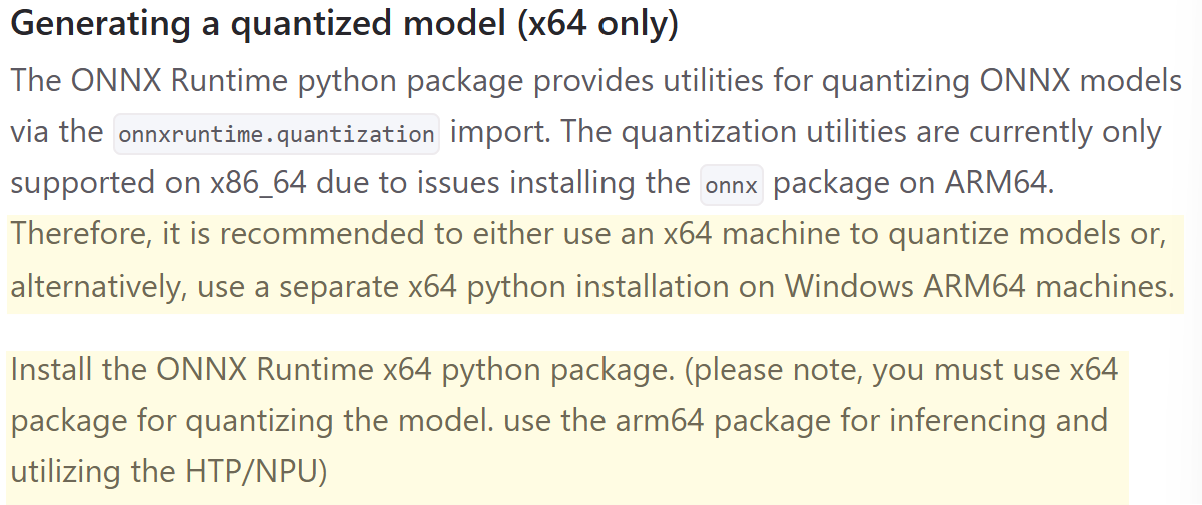


## Python Windows 64bit (x86_64)

In [33]:
# Let's first ensure we're using the correct platform that's necessary for inference
# To quantize model we need AMD64 (x86_64): 64-bit Python on 64-bit x86 architecture

import platform

arch = platform.machine()
sys = platform.system()
processor = platform.processor()
print(arch)
print(sys)
print(processor)

AMD64
Windows
ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc


In [5]:
# This works using Python x86_64
# Per directions use Python Windows 64 bit (x86_64)

In [6]:
import numpy as np
import onnxruntime
import random
import torch
import os
import re

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from onnxruntime.quantization import CalibrationDataReader
from PIL import Image
from typing import List,Tuple

random.seed(41)

https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/resnet50_data_reader.py

In [7]:
# def transform_numpy_opencv(image: np.ndarray, expected_shape) -> np.ndarray:
#     height, width = expected_shape[2], expected_shape[3]
#     # resize_image = np.array(Image.fromarray(image).resize((width, height), resample=Image.BICUBIC))
#     resized_image = cv.resize(image, (width, height), interpolation=cv.INTER_CUBIC)
    
#     #Normalize values to ensure pixels are between [0,1] HRNET expects this range
#     #Check paper to see if this is the expectation
    
#     float_image = resized_image.astype(np.float32) / 255.0
    
#     chw_image = np.transpose(float_image, (2,0,1)) # HWC -> CHW

#     return (float_image,chw_image)

In [8]:
class DataReader(CalibrationDataReader):
    def __init__(self, model_path:str, dataset_path:str, img_max: int=10, verbose=False) -> None:
        self.enum_data = None

        self.session = onnxruntime.InferenceSession(model_path, provider=["CPUExecutionProvider"])
        self.expected_inputs = self.session.get_inputs()[0]
        
        #Need to use expected name and shape for model quantization
        self.expected_name = self.expected_inputs.name
        self.expected_shape = self.expected_inputs.shape
        self.data_list = []

        self.transformer = v2.Compose([
            v2.Resize(size=(self.expected_shape[2], 
                            self.expected_shape[3]),
                            interpolation=InterpolationMode.BICUBIC),
            v2.PILToTensor(),
            v2.ConvertImageDtype(torch.float32),
        ])
        self.re_mapper = re.compile(r"^C:\\.+?\\Human_Action_Recognition\\test\\(?P<image>Image_\d{1,4}).jpg")
                
        img_files = [os.path.join(dataset_path,file) for file in os.listdir(dataset_path) if file.endswith(".jpg")]
        random.shuffle(img_files)
        for file in img_files[:img_max]:
            img_pil = Image.open(file)
            img_transformed = np.expand_dims(self._image_transformer(frame=img_pil), axis=0)
            if verbose:
                print(f"OG Image Shape: {np.array(img_pil).shape}")
                print(f"Transformed Shape: {img_transformed.shape}")
                

            self.data_list.append(img_transformed)
            
        self.data_size = len(self.data_list)    

    def _image_transformer(self, frame: Image) -> Image:
        transformed_frame = self.transformer(frame)
        transformed_frame_np = np.array(transformed_frame)
        return transformed_frame_np
        
        
    def get_next(self):
        # Updated this from resnet quantization example
        # https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/resnet50_data_reader.py
        if self.enum_data is None:
            self.enum_data = iter(
                [{self.expected_name: img_data} for img_data in self.data_list]
            )
        return next(self.enum_data, None)

    def rewind(self):
        self.enum_data = None

        



In [9]:
# iDataReader = DataReader(model_path=model_path, dataset_path=dataset_path, verbose=False)
# iDataReader.expected_shape

In [10]:
# iDataReader.data_size

In [11]:
# iDataReader.rewind()

In [12]:
#Remove np.expand_dims and set up example for users to solve with mismatched shape
# wrong input shape should be (3, 256, 192)
# iDataReader.rewind()
# while True:
#     data = iDataReader.get_next()
#     # update = np.expand_dims(data['image'],axis=0)
#     if data is None:
#         break
#     print(data['image'].shape)

In [13]:
dataset_path = os.path.join("C:\\","Users","DFS","Desktop","datasets","Human_Action_Recognition","test")
dataset_path

'C:\\Users\\DFS\\Desktop\\datasets\\Human_Action_Recognition\\test'

https://onnxruntime.ai/docs/execution-providers/QNN-ExecutionProvider.html#running-a-model-with-qnn-eps-htp-backend-python

In [1]:
# !powershell pip list

Package                   Version
------------------------- --------------
anyio                     4.8.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     24.3.0
babel                     2.16.0
backcall                  0.2.0
beautifulsoup4            4.12.3
bleach                    6.2.0
certifi                   2024.12.14
cffi                      1.17.1
charset-normalizer        3.4.1
colorama                  0.4.6
coloredlogs               15.0.1
comm                      0.2.2
debugpy                   1.8.11
decorator                 5.1.1
defusedxml                0.7.1
docopt                    0.6.2
executing                 2.1.0
fastjsonschema            2.21.1
filelock                  3.16.1
flatbuffers               24.3.25
fqdn                      1.5.1
fsspec                    2024.10.0
h11                       0.14.0
httpcor

In [21]:
!powershell python -m onnxruntime.quantization.preprocess --input "../models/hrnet_pose.onnx" --output "../models/hrnet_quantized_preprocessed_0129.onnx" 

In [31]:
from onnxruntime.quantization import QuantType, quantize, preprocess
from onnxruntime.quantization.execution_providers.qnn import get_qnn_qdq_config, qnn_preprocess_model

base_path = os.path.join("..","models")
model_path = os.path.join(base_path,"hrnet_pose.onnx")
output_model_path = os.path.join(base_path,"hrnet_quantized_0129.onnx")

#Pre-process original float32 model
pre_process_model_path = os.path.join(base_path,"hrnet_quantized_preprocessed_0129.onnx")

#Be sure this preprocess is actually preprocessing the onnx model
model_diff = qnn_preprocess_model(model_path, pre_process_model_path)
model_to_quantize = pre_process_model_path #if model_diff else model_path

iDataReader = DataReader(model_path=model_path, dataset_path=dataset_path, verbose=False)

qnn_config = get_qnn_qdq_config(model_to_quantize,  #
                                iDataReader,
                                activation_type=QuantType.QUInt16,
                                weight_type=QuantType.QUInt8)
qnn_config.__dict__

{'op_types_to_quantize': ['Sub', 'Add', 'Relu', 'Div', 'Conv', 'Resize'],
 'per_channel': False,
 'reduce_range': False,
 'weight_type': <QuantType.QUInt8: 1>,
 'activation_type': <QuantType.QUInt16: 4>,
 'nodes_to_quantize': [],
 'nodes_to_exclude': [],
 'use_external_data_format': False,
 'calibration_data_reader': <__main__.DataReader at 0x2c992225650>,
 'calibrate_method': <CalibrationMethod.MinMax: 0>,
 'quant_format': <QuantFormat.QDQ: 1>,
 'extra_options': {'MinimumRealRange': 0.0001,
  'DedicatedQDQPair': False,
  'QDQKeepRemovableActivations': False,
  'TensorQuantOverrides': {},
  'ActivationSymmetric': False,
  'WeightSymmetric': False,
  'CalibStridedMinMax': None,
  'UseQDQContribOps': True}}

In [32]:
quantize(model_to_quantize, output_model_path, qnn_config)

1. Download an x64 version of Python for windows (Windows x86-64) (not ARM64)
2. Install x64 Version
3. Set up windows alias for x64
4. Create virtual environment utilizing the x64 python
5. Activate virtual environment and rerun this notebook
   
**Generating a quantized model (x64 only)**
    
    The ONNX Runtime python package provides utilities for quantizing ONNX models via the onnxruntime.quantization import. The quantization utilities are currently only supported on x86_64 due to issues installing the onnx package on ARM64. Therefore, it is recommended to either use an x64 machine to quantize models or, alternatively, use a separate x64 python installation on Windows ARM64 machines.
    
    Install the ONNX Runtime x64 python package. (please note, you must use x64 package for quantizing the model. use the arm64 package for inferencing and utilizing the HTP/NPU)

**Adding Gotchas**
1. For model inference we need to use a Python version compatible with Windows ARM64 version 3.11.x</br>
   a. Check to see if QNN Execution Provider works with Python > 3.11</br>
2. To quantize a model you need to Python version compatible with Windows X64</br>
   a. Because of some weird dependancy you will not be able to run QNN </t>Execution Provider on Windows 64 therefore will need to switch back to </t>Windows ARM64 version (step 1).
3. Do not use Python version Windows ARM64 as stated in onnxruntime-qnn documents. Use Windows 64-bit ARM64 will then use emulator, not all modules available using Python ARM64 version
4. I think we need a separate ARM64 environment then use DLL to actually run quantized model. https://onnxruntime.ai/docs/execution-providers/QNN-ExecutionProvider.html
   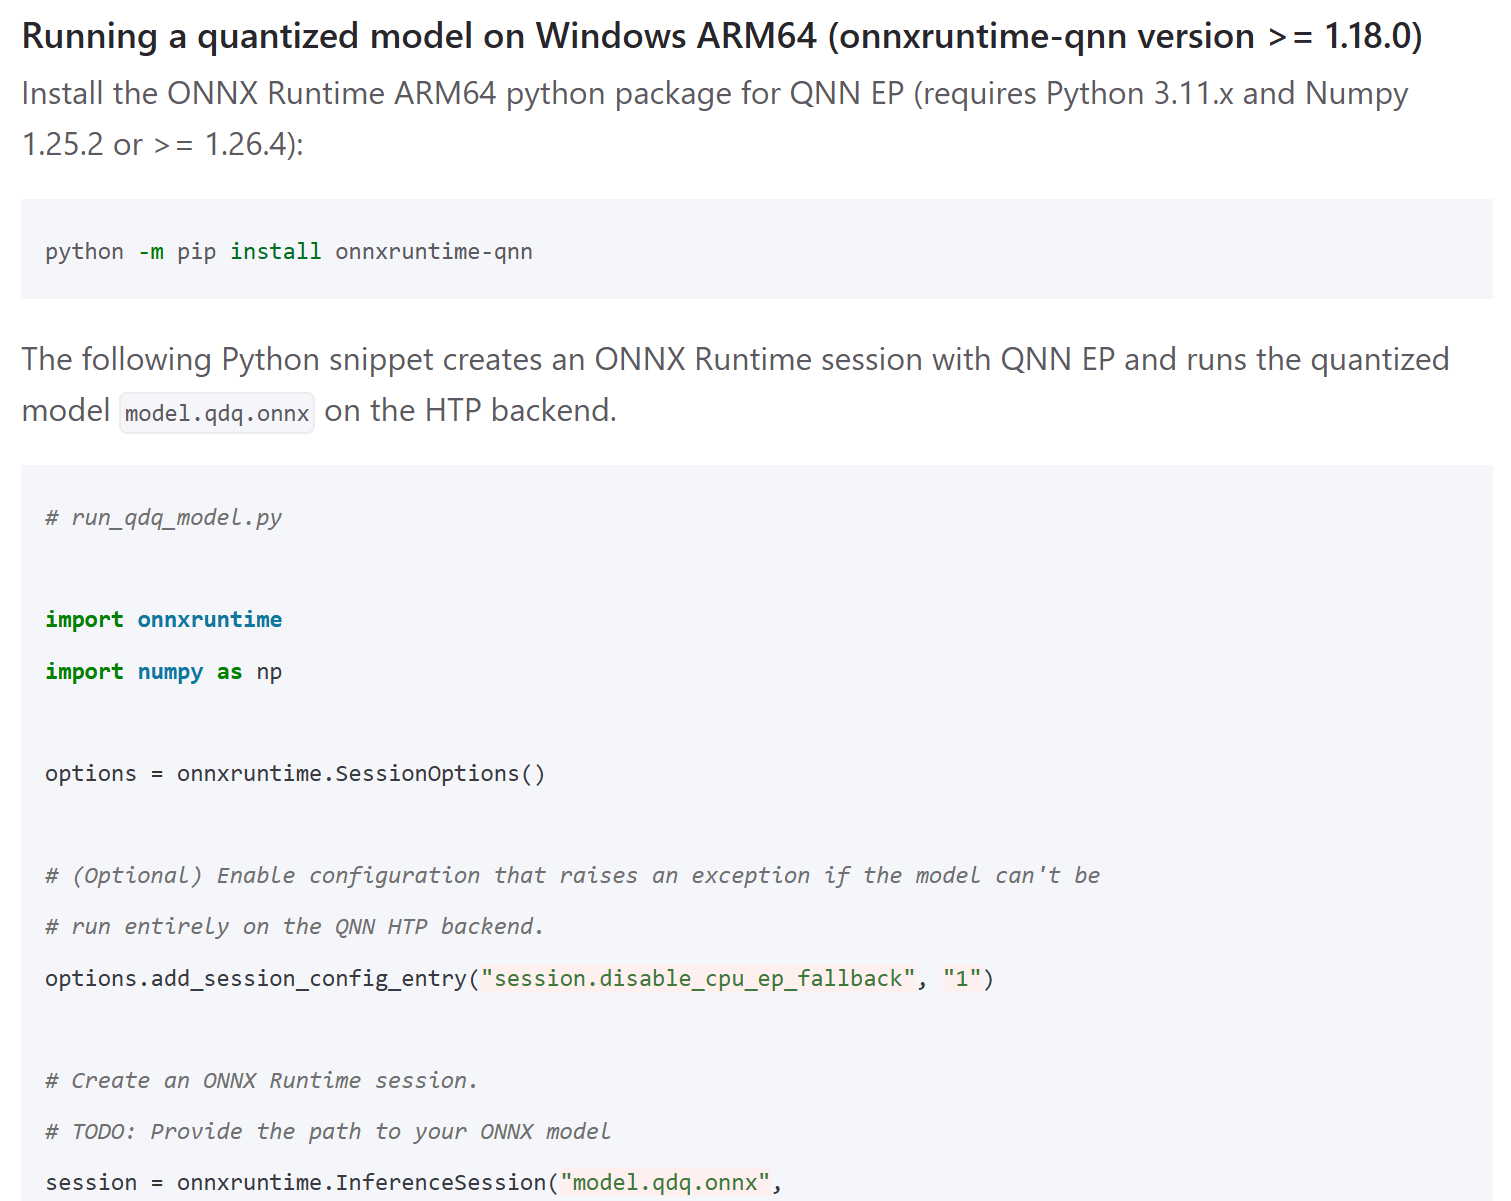